# Projet 2 : Analyse des données de systèmes éducatifs

## 0. Importations des modules et des données

In [1]:
## IMPORTATIONS
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline
#% matplotlib notebook
# graphes interactifs
import re
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
from IPython.display import Image
#import scipy.stats as st
#import statsmodels.api as sm
#from sklearn.datasets import load_iris
#iris_df_ori = load_iris()

####     A ESSAYER      #######################################################
# GRAPHES INTERACTIFS


# POUR LES GRAPHIQUES
# % matplotlib inline 
# plt.rcParams['figure.figsize'] = [9.5, 6] # ajuster la taille

# POUR DESACTIVER LA TOOLBOX GRAPHES TOP GRANDS
# %%javascript
# IPython.OutputArea.prototype._should_scroll = function(lines) {
#     return false;
# }

In [3]:
## FONCTION DONNANT DES INFOS SUR LA DIMENSION D'UNE DATAFRAME
def infos_df (df):
    infos = pd.DataFrame(df.dtypes).T.rename(index={0:'Type'}) 
    infos = infos.append(pd.DataFrame([df[col].size for col in df.columns],index=df.columns)\
                               .T.rename(index={0:'Nbe lignes'}))
    infos = infos.append(pd.DataFrame(df.isna().sum()).T.rename(index={0:'Nbe NaN'}))
    infos = infos.append(pd.DataFrame(infos.loc["Nbe lignes"]-infos.loc["Nbe NaN"])\
                         .T.rename(index = {0:"Nbe Entrées"}))
    infos = infos.append(pd.DataFrame(df.isna().sum()/df.shape[0]*100).T.rename(index={0:'% NaN'}))
    infos = infos.append(pd.DataFrame([df[col].unique().size for col in df.columns],index=df.columns)\
                               .T.rename(index={0:'Nbe uniques'}))
    return infos

In [36]:
## FONCTION D'EVALUATION DES VALEURS NULLES
def evalNull (df):
    # dataframe "Data" conservant seulement les lignes non entièrement nulles
    df_val_0 = df[df.columns[4:52]]\
        .dropna(axis = 0, how = 'all', inplace = False) # 357405 lin 48 col
    # dataframe "Data" conservant seulement les colonnes non entièrement nulles
    df_val_1 = df[df.columns[4:52]]\
        .dropna(axis = 1, how = 'all', inplace = False) # 357405 lin 48 col
    # Taille du tableau initial
    df_size = df[df.columns[4:52]].shape
    # Taille du tableau sans lignes nulles
    df_wo_null_lin = df_val_0.shape
    # Taille du tableau sans colonnes nulles
    df_wo_null_col = df_val_1.shape
    print("Taille du tableau initial : {}".format(df_size))
    print("Taille du tableau sans lignes nulles : {}".format(df_wo_null_lin))
    print("Taille du tableau sans colonnes nulles : {}".format(df_wo_null_col))
    print("Nbe/% de lignes nulles : {}/{:.1f}%"\
      .format((df_size[0]-df_wo_null_lin[0]),\
              (df_size[0]-df_wo_null_lin[0])*100/df_size[0]))
    print("Nbe de colonnes nulles : {}".format(df_size[1]-df_wo_null_lin[1]))

In [137]:
## FONCTION D'AFFICHAGE
def basic_plot(my_plot, my_x, my_y, my_x_t, xlab, ylab, my_tit, num_col):
    my_plot.plot(my_x, my_y, '-o', label = "% NaN", color = colors[num_col])
    my_plot.set_xlabel(xlab, fontsize = 14)
    my_plot.set_ylabel(ylab, fontsize = 14)
    plt.xticks(my_x_t, my_x_t, rotation=85 , fontsize = 14)
    plt.yticks(fontsize = 14) 
    my_plot.set_title(my_tit, fontsize = 18, fontweight = 'bold')
    plt.grid(color='grey', linestyle='dotted')

L'ensemble des données téléchargées se compose de 5 fichiers .csv et d'un fichier excel comportant 5 onglets.
Il semble que l'intégralité des données des fichiers .csv soit reprise dans chacun des onglets du fichier Excel.

Dans ce notebook, on appellera "base de donnée" l'ensemble des données, et "table" chacun des onglets ou fichier .csv correspondant.

On travaillera sur les cinq dataframes créées dans la cellule suivante :

In [2]:
# Utilisé la fonction dropna (colonne nulle) pour éliminer les colonnes fantômes "Unamed en fin de tableau"
data = pd.read_csv("../DONNEES/EdStatsData.csv").dropna(how='all', axis='columns')
country = pd.read_csv("../DONNEES/EdStatsCountry.csv").dropna(how='all', axis='columns')
cnt_ser = pd.read_csv("../DONNEES/EdStatsCountry-Series.csv").dropna(how='all', axis='columns')
series = pd.read_csv("../DONNEES/EdStatsSeries.csv").dropna(how='all', axis='columns')
footnote = pd.read_csv("../DONNEES/EdStatsFootNote.csv").dropna(how='all', axis='columns')

## 1. Evaluation de la qualité des données

### 1.0 Description globale des tables
- affichage du nombres et % de valeurs nulles, entrées uniques, et nombre de lignes
- tableau des grandeurs statistiques de base (sur les 48 colonnes années) : moyenne, médiane, Q1, Q3, écart type, min et max

In [4]:
###############
#     Data    #
###############
print("Pourcentage total de valeurs nulles ('Data') : {}".format(infos_df(data).loc["% NaN"].mean()))

Pourcentage total de valeurs nulles ('Data') : 85.89840022994153


In [5]:
inf_data = infos_df(data)
inf_data

,Country Name,Country Code,Indicator Name,Indicator Code,1970,1971,1972,1973,1974,1975,...,2055,2060,2065,2070,2075,2080,2085,2090,2095,2100
Type,object,object,object,object,float64,float64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
Nbe lignes,886930,886930,886930,886930,886930,886930,886930,886930,886930,886930,...,886930,886930,886930,886930,886930,886930,886930,886930,886930,886930
Nbe NaN,0,0,0,0,814642,851393,851311,851385,851200,799624,...,835494,835494,835494,835494,835494,835494,835494,835494,835494,835494
Nbe Entrées,886930,886930,886930,886930,72288,35537,35619,35545,35730,87306,...,51436,51436,51436,51436,51436,51436,51436,51436,51436,51436
% NaN,0,0,0,0,91.8496,95.9933,95.984,95.9924,95.9715,90.1564,...,94.2007,94.2007,94.2007,94.2007,94.2007,94.2007,94.2007,94.2007,94.2007,94.2007
Nbe uniques,242,242,3665,3665,24596,30893,30983,30989,31140,37839,...,8028,7915,7801,7701,7563,7467,7336,7151,7045,6915


In [6]:
desc_data = data.describe() # default : seulement les numeric ('1970' à '2100')
desc_data

,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,...,2055,2060,2065,2070,2075,2080,2085,2090,2095,2100
count,7.228800e+04,3.553700e+04,3.561900e+04,3.554500e+04,3.573000e+04,8.730600e+04,3.748300e+04,3.757400e+04,3.757600e+04,3.680900e+04,...,5.143600e+04,5.143600e+04,5.143600e+04,5.143600e+04,5.143600e+04,5.143600e+04,5.143600e+04,5.143600e+04,5.143600e+04,5.143600e+04
mean,1.974772e+09,4.253638e+09,4.592365e+09,5.105006e+09,5.401493e+09,2.314288e+09,5.731808e+09,6.124437e+09,6.671489e+09,7.436724e+09,...,7.145788e+02,7.224868e+02,7.271290e+02,7.283779e+02,7.266484e+02,7.228327e+02,7.176899e+02,7.113072e+02,7.034274e+02,6.940296e+02
std,1.211687e+11,1.804814e+11,1.914083e+11,2.059170e+11,2.112150e+11,1.375059e+11,2.215546e+11,2.325489e+11,2.473986e+11,2.660957e+11,...,2.136851e+04,2.215845e+04,2.287990e+04,2.352338e+04,2.408149e+04,2.455897e+04,2.496587e+04,2.530183e+04,2.556069e+04,2.574189e+04
min,-1.435564e+00,-1.594625e+00,-3.056522e+00,-4.032582e+00,-4.213563e+00,-3.658569e+00,-2.950945e+00,-3.174870e+00,-3.558749e+00,-2.973612e+00,...,-1.830000e+00,-1.630000e+00,-1.440000e+00,-1.260000e+00,-1.090000e+00,-9.200000e-01,-7.800000e-01,-6.500000e-01,-5.500000e-01,-4.500000e-01
25%,8.900000e-01,8.853210e+00,9.240920e+00,9.595200e+00,9.861595e+00,1.400000e+00,9.312615e+00,9.519913e+00,1.000000e+01,1.000000e+01,...,3.000000e-02,3.000000e-02,3.000000e-02,2.000000e-02,2.000000e-02,1.000000e-02,1.000000e-02,1.000000e-02,1.000000e-02,1.000000e-02
50%,6.317724e+00,6.316240e+01,6.655139e+01,6.969595e+01,7.087760e+01,9.677420e+00,7.101590e+01,7.133326e+01,7.290512e+01,7.510173e+01,...,2.300000e-01,2.300000e-01,2.300000e-01,2.300000e-01,2.300000e-01,2.300000e-01,2.300000e-01,2.300000e-01,2.300000e-01,2.200000e-01
75%,6.251250e+01,5.655200e+04,5.863650e+04,6.202900e+04,6.383675e+04,7.854163e+01,5.682800e+04,5.739175e+04,5.940425e+04,6.411500e+04,...,7.500000e+00,7.505000e+00,7.500000e+00,7.300000e+00,7.100000e+00,6.722500e+00,6.080000e+00,5.462500e+00,4.680000e+00,4.032500e+00
max,1.903929e+13,1.986457e+13,2.100916e+13,2.238367e+13,2.282991e+13,2.300634e+13,2.424128e+13,2.521383e+13,2.622101e+13,2.730873e+13,...,2.813670e+06,2.951569e+06,3.070879e+06,3.169711e+06,3.246239e+06,3.301586e+06,3.337871e+06,3.354746e+06,3.351887e+06,3.330484e+06


In [7]:
#data.select_dtypes(include = "object").describe() # pour n'afficher que les objets
#data.select_dtypes(include = "float").describe() # pour n'afficher que les float (idem describe par défaut)
data[data.columns[0:20]].describe(include='all') # pour forcer l'affichage de pls types

,Country Name,Country Code,Indicator Name,Indicator Code,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985
count,886930,886930,886930,886930,7.228800e+04,3.553700e+04,3.561900e+04,3.554500e+04,3.573000e+04,8.730600e+04,3.748300e+04,3.757400e+04,3.757600e+04,3.680900e+04,8.912200e+04,3.877700e+04,3.751100e+04,3.846000e+04,3.860600e+04,9.029600e+04
unique,242,242,3665,3665,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Slovenia,BLZ,Wittgenstein Projection: Mean years of schooli...,UIS.XSPENDP.2.FDPUB.FNCUR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,3665,3665,242,242,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,1.974772e+09,4.253638e+09,4.592365e+09,5.105006e+09,5.401493e+09,2.314288e+09,5.731808e+09,6.124437e+09,6.671489e+09,7.436724e+09,3.283898e+09,7.664969e+09,7.913722e+09,7.856908e+09,8.118002e+09,3.622763e+09
std,NaN,NaN,NaN,NaN,1.211687e+11,1.804814e+11,1.914083e+11,2.059170e+11,2.112150e+11,1.375059e+11,2.215546e+11,2.325489e+11,2.473986e+11,2.660957e+11,1.780774e+11,2.744142e+11,2.790549e+11,2.823809e+11,2.940635e+11,2.002929e+11
min,NaN,NaN,NaN,NaN,-1.435564e+00,-1.594625e+00,-3.056522e+00,-4.032582e+00,-4.213563e+00,-3.658569e+00,-2.950945e+00,-3.174870e+00,-3.558749e+00,-2.973612e+00,-1.404240e+00,-1.478345e+00,-2.358765e+00,-2.867273e+00,-2.800548e+00,-2.216315e+00
25%,NaN,NaN,NaN,NaN,8.900000e-01,8.853210e+00,9.240920e+00,9.595200e+00,9.861595e+00,1.400000e+00,9.312615e+00,9.519913e+00,1.000000e+01,1.000000e+01,1.770000e+00,9.468690e+00,9.989330e+00,9.581825e+00,9.068048e+00,2.150000e+00
50%,NaN,NaN,NaN,NaN,6.317724e+00,6.316240e+01,6.655139e+01,6.969595e+01,7.087760e+01,9.677420e+00,7.101590e+01,7.133326e+01,7.290512e+01,7.510173e+01,1.107000e+01,7.467213e+01,7.710972e+01,7.592528e+01,7.533138e+01,1.200000e+01
75%,NaN,NaN,NaN,NaN,6.251250e+01,5.655200e+04,5.863650e+04,6.202900e+04,6.383675e+04,7.854163e+01,5.682800e+04,5.739175e+04,5.940425e+04,6.411500e+04,8.202760e+01,6.310400e+04,6.923300e+04,6.304125e+04,6.360700e+04,8.338313e+01


In [8]:
data[data.columns[20:40]].describe()

,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005
count,3.937200e+04,3.864100e+04,3.855200e+04,3.754000e+04,1.244050e+05,7.443700e+04,7.554300e+04,7.579300e+04,7.746200e+04,1.313610e+05,7.680700e+04,7.345300e+04,8.491400e+04,1.188390e+05,1.766760e+05,1.235090e+05,1.242050e+05,1.303630e+05,1.288140e+05,1.841080e+05
mean,9.156550e+09,1.014901e+10,1.104709e+10,1.195436e+10,9.084424e+09,1.571674e+10,1.604668e+10,1.643532e+10,1.684022e+10,1.052543e+10,1.874630e+10,2.027385e+10,1.794678e+10,1.331558e+10,9.423384e+09,1.384867e+10,1.428299e+10,1.449393e+10,1.589729e+10,1.188637e+10
std,3.264675e+11,3.535351e+11,3.804257e+11,4.014873e+11,3.665667e+11,4.881357e+11,5.012055e+11,5.121962e+11,5.292982e+11,4.285218e+11,5.812586e+11,6.142357e+11,5.859148e+11,5.153472e+11,4.442374e+11,5.449242e+11,5.622886e+11,5.803607e+11,6.278337e+11,5.576181e+11
min,-1.556722e+00,-1.410886e+00,-1.425202e+00,-1.562425e+00,-1.803750e+00,-5.814339e+00,-5.089333e+00,-6.184857e+00,-4.792691e+00,-2.697722e+00,-3.820174e+00,-2.517245e+00,-6.086200e+04,-6.526000e+04,-6.759300e+04,-6.973700e+04,-9.214300e+04,-1.111860e+05,-1.262600e+05,-1.347240e+05
25%,9.332923e+00,9.595330e+00,9.715503e+00,9.679637e+00,4.830000e+00,5.134554e+01,4.933854e+01,4.944877e+01,4.783283e+01,5.200000e+00,4.836486e+01,5.510854e+01,3.346871e+01,1.749051e+01,5.699035e+00,1.599897e+01,1.584246e+01,1.550983e+01,1.418687e+01,5.720000e+00
50%,7.409428e+01,7.357014e+01,7.354275e+01,7.935322e+01,5.048379e+01,3.916000e+04,3.477300e+04,3.497100e+04,3.182500e+04,5.018663e+01,3.262400e+04,4.319600e+04,1.521400e+04,1.251000e+03,5.078717e+01,8.300000e+02,9.460000e+02,3.956150e+02,3.350000e+02,5.031512e+01
75%,6.608525e+04,7.001100e+04,7.597875e+04,8.558375e+04,9.134300e+04,4.383130e+05,4.246125e+05,4.316250e+05,4.244605e+05,7.954000e+04,4.371055e+05,4.909700e+05,3.768212e+05,1.867360e+05,3.343950e+04,1.746540e+05,1.770990e+05,1.474790e+05,1.584082e+05,2.993150e+04
max,3.271284e+13,3.388244e+13,3.545738e+13,3.678741e+13,4.714344e+13,4.781272e+13,4.866446e+13,4.959600e+13,5.106581e+13,5.275448e+13,5.478031e+13,5.695521e+13,5.835137e+13,6.040632e+13,6.327293e+13,6.477834e+13,6.654753e+13,6.906328e+13,7.278829e+13,7.624045e+13


In [9]:
data[data.columns[40:60]].describe()

,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2020,2025,2030,2035,2040,2045,2050,2055
count,1.403120e+05,1.372720e+05,1.343870e+05,1.421080e+05,2.424420e+05,1.460120e+05,1.472640e+05,1.375090e+05,1.137890e+05,1.310580e+05,1.646000e+04,143.000000,5.143600e+04,5.143600e+04,5.143600e+04,5.143600e+04,5.143600e+04,5.143600e+04,5.143600e+04,5.143600e+04
mean,1.684674e+10,1.872300e+10,2.029794e+10,1.894907e+10,1.189592e+10,2.117911e+10,2.176323e+10,2.425332e+10,2.678449e+10,2.353720e+10,1.934411e+11,2.160839,5.780697e+02,6.054774e+02,6.315916e+02,6.556516e+02,6.751516e+02,6.911287e+02,7.040640e+02,7.145788e+02
std,6.851484e+11,7.465688e+11,7.944132e+11,7.623650e+11,6.218710e+11,8.555853e+11,8.833955e+11,9.513016e+11,1.023180e+12,9.732465e+11,2.839188e+12,0.810584,1.475072e+04,1.577305e+04,1.678556e+04,1.778666e+04,1.874408e+04,1.965409e+04,2.052941e+04,2.136851e+04
min,-3.708940e+05,-3.882170e+05,-4.088540e+05,-4.561240e+05,-4.969050e+05,-5.709940e+05,-6.049930e+05,-6.157480e+05,-8.900000e+01,-2.467847e+00,-1.797539e+00,1.000000,-1.870000e+00,-2.000000e+00,-2.110000e+00,-2.150000e+00,-2.140000e+00,-2.090000e+00,-1.980000e+00,-1.830000e+00
25%,1.277624e+01,1.268661e+01,1.233467e+01,1.181939e+01,1.322703e+00,1.216330e+01,1.100000e+01,1.306113e+01,1.614639e+01,4.100000e-01,1.826761e+01,2.000000,6.000000e-02,6.000000e-02,6.000000e-02,6.000000e-02,5.000000e-02,5.000000e-02,4.000000e-02,3.000000e-02
50%,9.981849e+01,1.000000e+02,1.000000e+02,9.925039e+01,2.046020e+01,9.853510e+01,9.759012e+01,1.000000e+02,1.000000e+02,5.235000e+01,6.264000e+03,2.000000,2.300000e-01,2.300000e-01,2.300000e-01,2.300000e-01,2.300000e-01,2.300000e-01,2.300000e-01,2.300000e-01
75%,1.187198e+05,1.343790e+05,1.453855e+05,1.180412e+05,3.121000e+03,1.065065e+05,1.038168e+05,1.426480e+05,1.636440e+05,6.153575e+04,5.939590e+05,3.000000,6.660000e+00,6.900000e+00,7.062500e+00,7.300000e+00,7.400000e+00,7.432500e+00,7.500000e+00,7.500000e+00
max,8.031840e+13,8.469145e+13,8.711022e+13,8.677516e+13,9.134676e+13,9.506314e+13,9.999473e+13,1.054580e+14,1.108060e+14,1.156198e+14,1.206030e+14,4.000000,1.599479e+06,1.781898e+06,1.967258e+06,2.151416e+06,2.330336e+06,2.500439e+06,2.662071e+06,2.813670e+06


In [10]:
data[data.columns[60:80]].describe()

,2060,2065,2070,2075,2080,2085,2090,2095,2100
count,5.143600e+04,5.143600e+04,5.143600e+04,5.143600e+04,5.143600e+04,5.143600e+04,5.143600e+04,5.143600e+04,5.143600e+04
mean,7.224868e+02,7.271290e+02,7.283779e+02,7.266484e+02,7.228327e+02,7.176899e+02,7.113072e+02,7.034274e+02,6.940296e+02
std,2.215845e+04,2.287990e+04,2.352338e+04,2.408149e+04,2.455897e+04,2.496587e+04,2.530183e+04,2.556069e+04,2.574189e+04
min,-1.630000e+00,-1.440000e+00,-1.260000e+00,-1.090000e+00,-9.200000e-01,-7.800000e-01,-6.500000e-01,-5.500000e-01,-4.500000e-01
25%,3.000000e-02,3.000000e-02,2.000000e-02,2.000000e-02,1.000000e-02,1.000000e-02,1.000000e-02,1.000000e-02,1.000000e-02
50%,2.300000e-01,2.300000e-01,2.300000e-01,2.300000e-01,2.300000e-01,2.300000e-01,2.300000e-01,2.300000e-01,2.200000e-01
75%,7.505000e+00,7.500000e+00,7.300000e+00,7.100000e+00,6.722500e+00,6.080000e+00,5.462500e+00,4.680000e+00,4.032500e+00
max,2.951569e+06,3.070879e+06,3.169711e+06,3.246239e+06,3.301586e+06,3.337871e+06,3.354746e+06,3.351887e+06,3.330484e+06


In [11]:
###############
#   Country   #
###############
inf_country = infos_df(country)
inf_country

,Country Code,Short Name,Table Name,Long Name,2-alpha code,Currency Unit,Special Notes,Region,Income Group,WB-2 code,...,Government Accounting concept,IMF data dissemination standard,Latest population census,Latest household survey,Source of most recent Income and expenditure data,Vital registration complete,Latest agricultural census,Latest industrial data,Latest trade data,Latest water withdrawal data
Type,object,object,object,object,object,object,object,object,object,object,...,object,object,object,object,object,object,object,float64,float64,object
Nbe lignes,241,241,241,241,241,241,241,241,241,241,...,241,241,241,241,241,241,241,241,241,241
Nbe NaN,0,0,0,0,3,26,96,27,27,1,...,80,60,28,100,81,130,99,134,56,62
Nbe Entrées,241,241,241,241,238,215,145,214,214,240,...,161,181,213,141,160,111,142,107,185,179
% NaN,0,0,0,0,1.24481,10.7884,39.834,11.2033,11.2033,0.414938,...,33.195,24.8963,11.6183,41.4938,33.61,53.9419,41.0788,55.6017,23.2365,25.7261
Nbe uniques,241,241,241,241,239,153,132,8,6,241,...,3,3,28,61,76,3,36,12,14,21


In [12]:
#country.select_dtypes(include = "object").describe() # pour n'afficher que les objets
#country.select_dtypes(include = "float").describe() # pour n'afficher que les float (idem describe par défaut)
desc_country = country.describe(include='all')
desc_country

,Country Code,Short Name,Table Name,Long Name,2-alpha code,Currency Unit,Special Notes,Region,Income Group,WB-2 code,...,Government Accounting concept,IMF data dissemination standard,Latest population census,Latest household survey,Source of most recent Income and expenditure data,Vital registration complete,Latest agricultural census,Latest industrial data,Latest trade data,Latest water withdrawal data
count,241,241,241,241,238,215,145,214,214,240,...,161,181,213,141,160,111,142,107.000000,185.000000,179
unique,241,241,241,241,238,152,131,7,5,240,...,2,2,27,60,75,2,35,NaN,NaN,20
top,PHL,Iraq,Iraq,Middle East & North Africa (developing only),CR,Euro,April 2012 database update: Based on official ...,Europe & Central Asia,Upper middle income,CR,...,Consolidated central government,General Data Dissemination System (GDDS),2011,"World Health Survey (WHS), 2003","Integrated household survey (IHS), 2012",Yes,2010,NaN,NaN,2000
freq,1,1,1,1,1,23,6,57,55,1,...,95,110,59,10,15,110,36,NaN,NaN,40
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2008.102804,2010.994595,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.616834,2.569675,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000.000000,1995.000000,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2007.500000,2011.000000,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2009.000000,2012.000000,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010.000000,2012.000000,NaN


In [13]:
#################
#     Series    #
#################
inf_series = infos_df(series)
inf_series

,Series Code,Topic,Indicator Name,Short definition,Long definition,Periodicity,Base Period,Other notes,Aggregation method,Limitations and exceptions,General comments,Source,Statistical concept and methodology,Development relevance,Related source links
Type,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object
Nbe lignes,3665,3665,3665,3665,3665,3665,3665,3665,3665,3665,3665,3665,3665,3665,3665
Nbe NaN,0,0,0,1509,0,3566,3351,3113,3618,3651,3651,0,3642,3662,3450
Nbe Entrées,3665,3665,3665,2156,3665,99,314,552,47,14,14,3665,23,3,215
% NaN,0,0,0,41.1733,0,97.2988,91.4325,84.9386,98.7176,99.618,99.618,0,99.3724,99.9181,94.1337
Nbe uniques,3665,37,3665,1170,2060,2,5,15,4,10,9,31,3,2,2


In [95]:
#########################
#     Country-Series    #
#########################
inf_cnt_ser = infos_df(cnt_ser)
inf_cnt_ser

,CountryCode,SeriesCode,DESCRIPTION
Type,object,object,object
Nbe lignes,613,613,613
Nbe NaN,0,0,0
Nbe Entrées,613,613,613
% NaN,0,0,0
Nbe uniques,211,21,97


In [96]:
#################
#    FootNote   #
#################
inf_footnote = infos_df(footnote)
inf_footnote

,CountryCode,SeriesCode,Year,DESCRIPTION
Type,object,object,object,object
Nbe lignes,643638,643638,643638,643638
Nbe NaN,0,0,0,0
Nbe Entrées,643638,643638,643638,643638
% NaN,0,0,0,0
Nbe uniques,239,1558,56,9102


### ----------------- Bilan description globale ------------- 
1. La table "Data" est composée de 886930 lignes qui correspondent à toutes les combinaisons des entrées uniques des colonnes "Country Code" et "Indicator Code" (respectivement 242 et 3665 entrées uniques). On trouve dans chaque ligne correspondant à un couple Indicateur/Pays la valeur d'un indicateur pour un pays. Les colonnes détaillent les valeurs pour chaque année de 1970 à 2017 (48 colonnes), puis des projections de ces valeurs tous les 5 ans des années 2020 à 2100 (17 colonnes) 
2. La table "Country" est composée de 241 lignes correspondant aux pays sur lesquels portent les données. (Il manque un pays, voir plus bas). Chaque colonne donne des renseignements sur les pays.
3. La table "Series" est composée de 3665 lignes correspondant chacune à un indicateur statistique.
4. La table "Country-series" comporte 613 lignes donne des indications sur les sources des données de divers couples Indicateur/Pays.
5. La table "FootNote" comporte 643638 lignes, et donne des précisions (mode de calcul ou autre) relatives à divers couples Indicateur/Pays.

L'analyse de la composition des tables a permis de déduire le MPD (Modèle Physique de Données) de la base représenté ci-dessous :

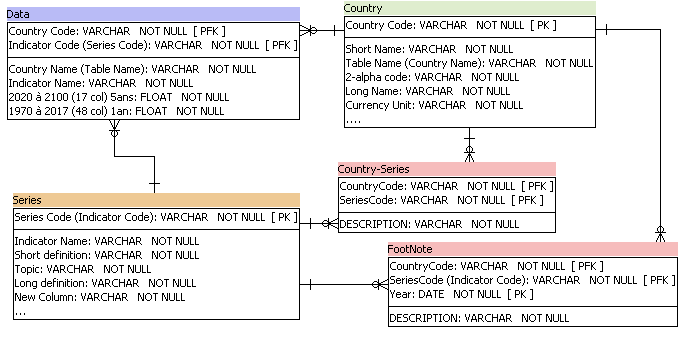

In [99]:
Image("../UML/EduStatsMPD.png")

Les clés proposées dans le MPD ci-dessus pour chaque jeu faciliteraient l'utilisation de la base, sous réserve de quelques modifications :
- renommer certaines colonnes afin de lever les ambiguïtés
(ex : Series/"Series Code" -> Series/"Indicator Code")
- supprimer les colonnes redondantes ou inutiles
(ex : Data/"Country Name", accessibles via la clé étrangère "Country Code" en colonne Country/"Table Name")

### 1.1 Taux de remplissage des tables et données manquantes
#### Table "Data"

In [37]:
evalNull(data)

Taille du tableau initial : (886930, 48)
Taille du tableau sans lignes nulles : (357405, 48)
Taille du tableau sans colonnes nulles : (886930, 48)
Nbe/% de lignes nulles : 529525/59.7%
Nbe de colonnes nulles : 0


In [33]:
# nbe de remplissage minimum et année correspondante
val_min = desc_data.T["count"].min()
print("année nbe entrées min, nbe entrées min : {}, {:.0f}, soit {:.3f}%"\
      .format(desc_data.T["count"].index[desc_data.T["count"]==val_min], \
              val_min, val_min*100/data_size[0]))

# nbe de remplissage maximum et année correspondante
val_max = desc_data.T["count"].max()
print("année nbe entrées max, nbe entrées max : {}, {:.0f}, soit {:.3f}%"\
     .format(desc_data.T["count"].index[desc_data.T["count"]==val_max], \
             val_max, val_max*100/data_size[0]))

année nbe entrées min, nbe entrées min : Index(['2017'], dtype='object'), 143, soit 0.016%
année nbe entrées max, nbe entrées max : Index(['2010'], dtype='object'), 242442, soit 27.335%


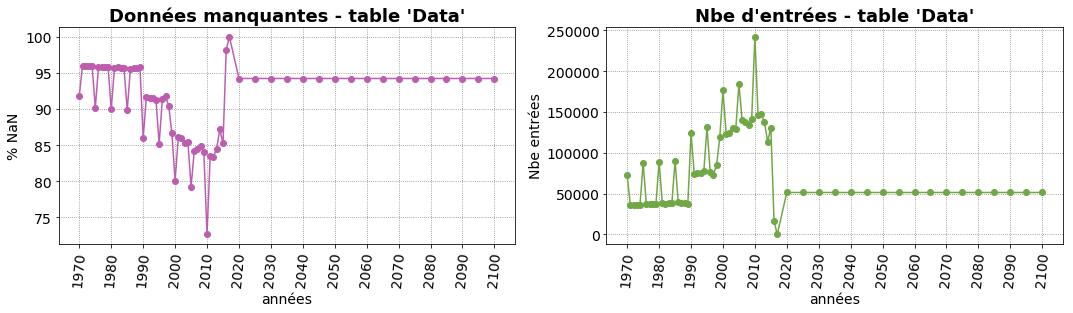

In [146]:
fig = plt.figure(figsize = (18,4))

colors = ["#bd5db0","#70a845","#727bcc","#b49242","#cc566c","#4aad92","#ca6037"]

x=inf_data.columns[4:].astype(int) # titres des colonnes de 1970 à 2100
xlab=np.arange(1970,2104,10)#['' if (val%4 != 0) else val for val in range(1970,2100)]
y1=inf_data.loc["% NaN"][4:] # nombre de valeurs nulles
y2=inf_data.loc["Nbe Entrées"][4:] # nombre de valeurs nulles

plot1 = plt.subplot(1,2,1)
basic_plot(plot1, x, y1, xlab, "années", "% NaN",  "Données manquantes - table 'Data'", 0)

plot2 = plt.subplot(1,2,2)
basic_plot(plot2, x, y2, xlab, "années", "Nbe entrées",  "Nbe d'entrées - table 'Data'", 1)

plt.show()

- La table "Data" donnant la valeur d'un indicateur pour une année comporte environ 86 % de données non renseignées.
- Environ 60% de l'ensemble des couples Indicateur/Pays n'a aucune valeur renseignée.
- Le nombre de données disponibles croî avec les années : elles sont 3 fois plus nombreuses par année dans la plage 2000-2015 que dans la plage 1970-1990.
- L'année la mieux renseignée est l'année 2010 (27% des couples Indicateur/Pays, soit plus de 242 000 valeurs), et les moins renseignées sont les années 2016 et 2017 (respectivement 1,8% et 0,016% des couples, soit 16460 et 143 valeurs)

#### Table "Country"

In [38]:
evalNull(country)

Taille du tableau initial : (241, 27)
Taille du tableau sans lignes nulles : (241, 27)
Taille du tableau sans colonnes nulles : (241, 27)
Nbe/% de lignes nulles : 0/0.0%
Nbe de colonnes nulles : 0


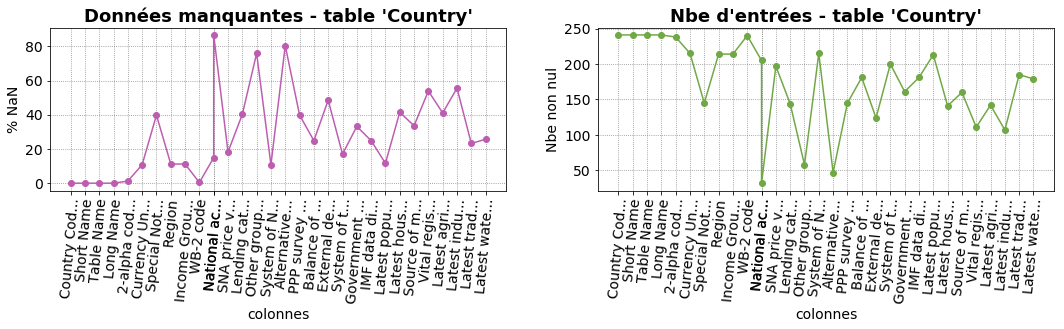

In [298]:
fig = plt.figure(figsize = (18,3))

x=inf_country.columns
xlab=[my_str[:11]+"..." if len(my_str)>11 else my_str for my_str in x]
y1=inf_country.loc["% NaN"] # nombre de valeurs nulles
y2=inf_country.loc["Nbe Entrées"] # nombre de valeurs nulles

plot1 = plt.subplot(1,2,1)
basic_plot(plot1, xlab, y1, xlab, "colonnes", "% NaN",  "Données manquantes - table 'Country'", 0)

plot2 = plt.subplot(1,2,2)
basic_plot(plot2, xlab, y2, xlab, "colonnes", "Nbe non nul",  "Nbe d'entrées - table 'Country'", 1)

plt.show()

#### Table "Series"

In [49]:
evalNull(series)

Taille du tableau initial : (241, 27)
Taille du tableau sans lignes nulles : (241, 27)
Taille du tableau sans colonnes nulles : (241, 27)
Nbe/% de lignes nulles : 0/0.0%
Nbe de colonnes nulles : 0


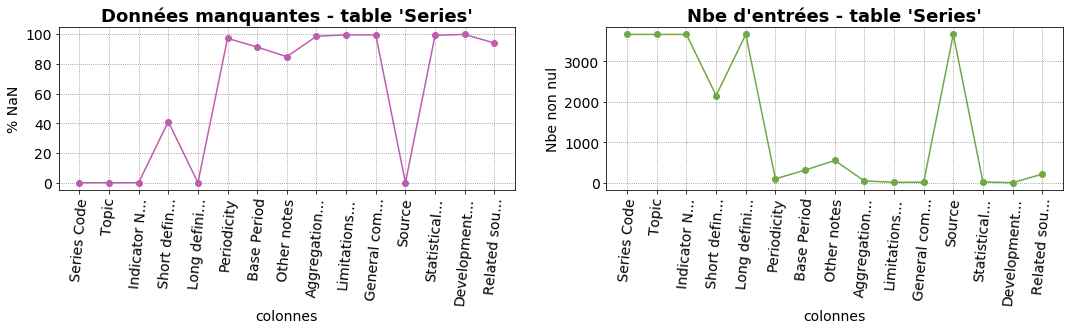

In [299]:
fig = plt.figure(figsize = (18,3))

x=inf_series.columns
xlab=[my_str[:11]+"..." if len(my_str)>11 else my_str for my_str in x]
y1=inf_series.loc["% NaN"] # nombre de valeurs nulles
y2=inf_series.loc["Nbe Entrées"] # nombre de valeurs nulles

plot1 = plt.subplot(1,2,1)
basic_plot(plot1, xlab, y1, xlab, "colonnes", "% NaN",  "Données manquantes - table 'Series'", 0)

plot2 = plt.subplot(1,2,2)
basic_plot(plot2, xlab, y2, xlab, "colonnes", "Nbe non nul",  "Nbe d'entrées - table 'Series'", 1)

plt.show()

#### Table "Country-Series"

In [51]:
evalNull(cnt_ser)

Taille du tableau initial : (613, 0)
Taille du tableau sans lignes nulles : (0, 0)
Taille du tableau sans colonnes nulles : (613, 0)
Nbe/% de lignes nulles : 613/100.0%
Nbe de colonnes nulles : 0


In [104]:
print("la table 'CountrySeries' contient {} entrées nulles".format(inf_cnt_ser.loc["Nbe NaN"].sum()))

la table 'CountrySeries' contient 0 entrées nulles


#### Table "FootNote"

In [101]:
evalNull(footnote)

Taille du tableau initial : (643638, 0)
Taille du tableau sans lignes nulles : (0, 0)
Taille du tableau sans colonnes nulles : (643638, 0)
Nbe/% de lignes nulles : 643638/100.0%
Nbe de colonnes nulles : 0


In [105]:
print("la table 'FootNote' contient {} entrées nulles".format(inf_footnote.loc["Nbe NaN"].sum()))

la table 'FootNote' contient 0 entrées nulles


## 2. Vérification et rectification de la qualité des données

On crée 5 nouvelles dataframes "data_c", "country_c", "series_c", "cnt_ser_c" et "footnote_c" qui contiendront les données rectifiées

In [438]:
data_c = data
country_c = country
series_c = pd.DataFrame([])
cnt_ser_c = pd.DataFrame([])
footnote_c = pd.DataFrame([])

### 2.1 Données dupliquées ou contradictoires

#### Détection des doublons : vérification de l'unicité des clés de chaque base

La description ci-dessus nous a permis de déterminer les colonnes de chaque bases susceptibles de jouer le rôle de clés. Afin de faciliter l'exploitation de la base, il est important que la clé de chaque table soit unique.
Vérifions donc que les tables sont exemptes de doublons :

In [399]:
# Fonction vérifiant l'unicité des lignes d'une liste de listes
def uniCle (t_tab): 
    if isinstance(t_tab[0], type(str)) :
        uni = list(set(t_tab))
        res = True if (len(uni)==len(t_tab)) else False
    else :
        uni = list(set(zip(*t_tab))) # liste des combinaisons uniques
        res = True if (len(uni)==len(t_tab[0])) else False
    return res

In [400]:
print("Table Data : Unicité de la clé ('Country Code'&'Indicator Code') {}"\
      .format(uniCle([data["Country Code"], data["Indicator Code"]])))
print("Table Country : Unicité de la clé ('Country Code') {}"\
      .format(uniCle(country["Country Code"])))
print("Table Series : Unicité de la clé ('Series Code') {}"\
      .format(uniCle(series["Series Code"])))
print("Table Country-Series : Unicité de la clé ('CountryCode'&'SeriesCode') {}"\
      .format(uniCle([cnt_ser["CountryCode"], cnt_ser["SeriesCode"]])))
print("Table FootNote : Unicité de la clé ('CountryCode'&'SeriesCode'&'Year') {}"\
      .format(uniCle([footnote["CountryCode"],footnote["SeriesCode"],footnote["Year"]])))

Table Data : Unicité de la clé ('Country Code'&'Indicator Code') True
Table Country : Unicité de la clé ('Country Code') True
Table Series : Unicité de la clé ('Series Code') True
Table Country-Series : Unicité de la clé ('CountryCode'&'SeriesCode') True
Table FootNote : Unicité de la clé ('CountryCode'&'SeriesCode'&'Year') True


Les tables sont bien exemptes de doublons. Pour plus de clarté, on renomme les colonnes contenant des entrées apparentées :

In [444]:
country_c.rename(columns={'Table Name':'Country Name'}, inplace=True)
series_c.rename(columns={'Series Code':'Indicator Code'}, inplace=True)
cnt_ser_c.rename(columns={'Country Code':'Country Code',
                          'SeriesCode':'Indicator Code',
                         'DESCRIPTION':'Description'}, inplace=True)
footnote_c.rename(columns={'Country Code':'Country Code',
                          'SeriesCode':'Indicator Code',
                         'DESCRIPTION':'Description'}, inplace=True)

#### Correspondance des entrées uniques des tables (clés communes)

- Les tables "Data" et "Country" n'ont pas le même nombre d'entrée uniques pour la colonne "Country Code" (voir dataframes inf_data et inf_country) : la table "Country" contient un pays en moins. On cherche à déterminer ce pays :

In [401]:
# Fonction qui trouve les éléments différents dans deux tableaux (réciproque)
# compare puis donne les entrées spécifiques à tab1, puis à tab2
def Diff(tab1, tab2): 
    tab_dif = [i for i in tab1 + tab2 if i not in tab1 or i not in tab2] 
    return (set(tab1)-set(tab2),set(tab2)-set(tab1))

In [502]:
cnt_lack = Diff(list(data["Country Code"].unique()),list(country["Country Code"].unique()))
print("Codes des pays spécifiques à 'Data' : {}"\
  .format(pays[0]))
print("Codes des pays spécifiques à 'Country' : {}"\
  .format(pays[1]))
nom_vgb = list(data[data["Country Code"]=='VGB']["Country Name"].unique())
print("Nom du pays à ajouter : {}".format(nom_vgb))

Codes des pays spécifiques à 'Data' : {'VGB'}
Codes des pays spécifiques à 'Country' : set()
Nom du pays à ajouter : ['British Virgin Islands']


La table Country étant supposée renseigner sur tous les pays présents dans la base, on rajoute une ligne dans la base "Country" contenant le pays manquant :

In [ ]:
###### A CORRIGER #######
nom_vgb = list(data[data["Country Code"]=='VGB']["Country Name"].unique())
#print("Noms du pays de code 'VGB' : {}".format(nom_vgb))
print(country_c.shape)
line = pd.DataFrame([['VGB',nom_vgb[0]]], columns = ["Country Code", "Country Name"])
#country_c.append(, sort = True)
country_c = country_c.sort_values("Country Code")
#country_c[country_c["Country Code"]=='VGB']
country_c.iloc[231]

- Les tables "Data" et "Series" ont bien le même nombre d'entrée uniques pour la colonne "Indicator Code" et "Series Code" (voir dataframes inf_data et inf_country) : 3665. Vérifions  que ces entrées uniques son bien les mêmes :

In [430]:
serie_lack = Diff(list(data["Indicator Code"].unique()),list(series["Series Code"].unique()))

print("Nbe d'indicateurs spécifiques à 'Data' : {}"\
  .format(len(serie_lack[0])))
print("Nbe d'indicateurs spécifiques à 'Series' : {}"\
  .format(len(serie_lack[1])))
print("Quelques indicateurs spécifiques à 'Data' :\n {}"\
  .format(sorted(serie_lack[0])[:5]))
print("Quelques indicateurs spécifiques à 'Series' :\n {}"\
  .format(sorted(serie_lack[1])[:5]))

Nbe d'indicateurs spécifiques à 'Data' : 53
Nbe d'indicateurs spécifiques à 'Series' : 53
Quelques indicateurs spécifiques à 'Data' :
 ['SE.SEC.DURS.LO', 'SE.SEC.ENRR.UP.FE', 'UIS.AIR.1.GLAST.GPI', 'UIS.CEAGE.1', 'UIS.E.0.PU.F']
Quelques indicateurs spécifiques à 'Series' :
 ['SE.SEC.DURS.LO ', 'SE.SEC.ENRR.UP.FE ', 'UIS.AIR.1.Glast.GPI', 'UIS.CEAge.1', 'UIS.E.0.Pu.F']


L'échantillon d'indicateurs affichés ci-dessus ne diffèrent en fait que par 1) des espaces 2) des lettres en minuscule dans la table "Series". Vérifions qu'après correction les entrées sont les mêmes :

In [429]:
test_ser = pd.Series([series["Series Code"][i].upper().replace(" ", "")\
                for i in range(series["Series Code"].index.size)],\
                 index = series["Series Code"].index)
test_data = pd.Series([data["Indicator Code"][i].upper().replace(" ", "")\
                for i in range(data["Indicator Code"].index.size)],\
                 index = data["Indicator Code"].index)
lack1 = Diff(list(data["Indicator Code"].unique()),list(test_ser.unique()))
lack2 = Diff(list(test_data.unique()), list(series["Series Code"].unique()))
lack3 = Diff(list(test_data.unique()), list(test_ser.unique()))

print("-----Correction de 'Series' seule :-----")
print("Nbe d'indicateurs spécifiques à 'Data', puis 'Series' : {}, {}"\
  .format(len(lack1[0]), len(lack1[1])))
print("-----Correction de 'Data' seule :-----")
print("Nbe d'indicateurs spécifiques à 'Data', puis 'Series' : {}, {}"\
  .format(len(lack2[0]), len(lack2[1])))
print("-----Correction de 'Data' et 'Series' :-----")
print("Nbe d'indicateurs spécifiques à 'Data', puis 'Series' : {}, {}"\
  .format(len(lack3[0]), len(lack3[1])))

-----Correction de 'Series' seule :-----
Nbe d'indicateurs spécifiques à 'Data', puis 'Series' : 5, 5
-----Correction de 'Data' seule :-----
Nbe d'indicateurs spécifiques à 'Data', puis 'Series' : 58, 58
-----Correction de 'Data' et 'Series' :-----
Nbe d'indicateurs spécifiques à 'Data', puis 'Series' : 0, 0


Remarque : La correction des noms des deux bases était nécessaire.

- Vérifions que les pays et les indicateurs présents dans les tables "Country-Series" et "Footnote" sont bien dans la liste des indicateurs de la table "Series" et dans la liste des pays de la table "Country" :

In [509]:
cnt_ser_lack1 = Diff(list(series["Series Code"].unique()),list(cnt_ser["SeriesCode"].unique()))
cnt_ser_lack2 = Diff(list(country["Country Code"].unique()),list(cnt_ser["CountryCode"].unique()))
footnote_lack1 = Diff(list(series["Series Code"].unique()),list(footnote["SeriesCode"].unique()))
footnote_lack2 = Diff(list(country["Country Code"].unique()),list(footnote["CountryCode"].unique()))

print("-------- table 'CountrySeries' --------")
print("Nbe d'indicateurs/de pays spécifiques à 'Series'/'Country' : {}/{}"\
  .format(len(cnt_ser_lack1[0]), len(cnt_ser_lack2[0])))
print("Nbe d'indicateurs/de pays spécifiques à 'Country-Series' : {}/{}"\
  .format(len(cnt_ser_lack1[1]), len(cnt_ser_lack2[1])))
print("-------- table 'FootNote' --------")
print("Nbe d'indicateurs/de pays spécifiques à 'Series'/'Country' : {}/{}"\
  .format(len(footnote_lack1[0]), len(footnote_lack2[0])))
print("Nbe d'indicateurs/de pays spécifiques à 'FootNote' : {}/{}"\
  .format(len(footnote_lack1[1]), len(footnote_lack2[1])))

-------- table 'CountrySeries' --------
Nbe d'indicateurs/de pays spécifiques à 'Series'/'Country' : 3644/30
Nbe d'indicateurs/de pays spécifiques à 'Country-Series' : 0/0
-------- table 'FootNote' --------
Nbe d'indicateurs/de pays spécifiques à 'Series'/'Country' : 2213/3
Nbe d'indicateurs/de pays spécifiques à 'FootNote' : 106/1


In [ ]:
###### indicate

#### Simplification de la base par fusion des tables

- On souhaite ensuie tester la correspondance bijective entre plusieurs paires de colonnes d'une même table afin de pouvoir répondre à des questions du type :

> __Une entrée de 'nom_col1' correspond-elle à une et une seule entrée de la colonne 'nom_col2' dans la table 'df' ?__

On crée une fonction pour cela :

In [11]:
# Fonction comparant la correspondance unique entre les valeurs d'une même ligne de deux colonnes d'une base
# (bijection entre les valeurs de col1 et de col2)

def Adeq (df, nom_col1,nom_col2):
    mon_zip = zip(df[nom_col1], df[nom_col2]) # associe les entrées des deux colonnes en tuples
    nbe_comb = len(set(mon_zip)) # retourne les valeurs uniques des tuples
    return nbe_comb==df[nom_col1].unique().size # si le nbe est le même que les valeurs uniques, c'est bon

# Version très lourde de la même fonction
# def Adeq_Col(df, nom_col1,nom_col2): # dans une même base df
#     tab = []
#     for i in range(len(df[nom_col1].unique())):
#         uni_i = df[nom_col1].unique()[i]
#         # liste des valeurs de col2 correspondant à la ième valeur unique de col1
#         li = df[df[nom_col1]==uni_i][nom_col2]
#         temp = 0
#         for j in range(len(li)): # comparaison de toutes les valeurs de li une à une
#             if li.iloc[j] != li.iloc[0]: # on prend la première valeur (0) comme référence
#                 temp+=1
#         tab.append(temp)
#     return temp # la valeur retournée est le nombre de valeurs différentes

Puis on teste les couples de colonnes listés ci-dessous :
- Table "Data" : "Country Code", "Country Name"
- Table "Data" : "Indicator Code", "Indicator Name"
- Table "Country" : "Country Code", "Short Name"
- Table "Country" : "Country Code", "Table Name"
- Table "Country" : "Country Code", "Long Name"
- Table "Series" : "Series Code", "Indicator Name"

In [12]:
print("Data : {} {}"\
      .format(Adeq(data, "Country Code", "Country Name"), Adeq(data, "Indicator Code", "Indicator Name")))
print("Country : {} {} {}"\
      .format(Adeq(country, "Country Code", "Short Name"), Adeq(country, "Country Code", "Table Name"),\
        Adeq(country, "Country Code", "Long Name")))
print("Series : {}".format(Adeq(series, "Series Code", "Indicator Name")))

Data : True True
Country : True True True
Series : True


Y a-t-il la même correspondance entre les codes pays ("Country Code") et les noms de pays dans les tables "Data" ("Country Name") et "Country" ("Table Name") ?
Si oui, on ne gardera qu'une des deux colonnes.

In [14]:
#set(zip(sorted(data["Country Name"].unique()), sorted(country["Table Name"].unique())))
data_gb_cnt = data.groupby("Country Code").count() #"Country Name"

##### Noms et codes des indicateurs statistiques

On remarque que malgré les noms différents, les colonnes "Indicator Code" de la table "Data" et "Series Code" de la table "Series" semblent faire référence au même code d'indicateur statistique, et ont, elles aussi, le même nombre d'entrées uniques de 3665.
Regardons si les entrées uniques de ces deux colonnes correspondent :

In [15]:
code = Diff_bis(list(data["Indicator Code"].unique()),list(series["Series Code"].unique()))
len(code[0]),len(code[1])

(53, 53)

53 entrées uniques de la colonne "Indicator Code" de la table "Data" ne sont pas dans la table "Series" et que le même nombre 53 d'entrées uniques de la colonne "Series Code" ne sont pas dans la table "Data".

In [16]:
list(code[0])[:2], list(code[1])[:2]

(['UIS.LR.AG65.F', 'UIS.FOSEP.56.FUK.F'], ['UIS.E.23.Pu', 'UIS.SLE.1t6.GPI'])

On constate que tous les codes différents de la colonne "Series Code" (table "Series") ont certaines lettres en minuscule.
Essayons donc de mettre toutes les entrées en majuscule et de refaire la comparaison.

On remarque par ailleurs que les colonnes "Indicator Name" des tables "Data" et "Series" ont le même nombre d'entrées uniques (3665). Vérifions si ces entrées uniques correspondent :

In [21]:
indic = Diff_bis(list(data["Indicator Name"].unique()),list(series["Indicator Name"].unique()))
len(indic[0]), len(indic[1])

(462, 462)

On remarque que 462 entrées uniques de la colonne "Indicator Name" de la table "data" ne sont pas dans la table "series" et que le même nombre 462 d'entrées uniques de la même colonne de la table "series" ne sont pas dans la table "data".

Cela pourrait-il indiquer qu'il s'agirait des mêmes entrées qui ne présentent que de petites variations d'écriture, comme c'est le cas pour les deux entrées ci-dessous ?

In [22]:
indic = Diff_bis(list(data["Indicator Code"].unique()),list(series["Series Code"].unique()))
len(indic[0]), len(indic[1])

(53, 53)

In [23]:
list(indic[0])[7],list(indic[1])[8]

('UIS.E.4.PU.F', 'UIS.NIR.1.AgP1.F')

In [24]:
a = data["Indicator Code"][data["Indicator Name"]=='SABER: (School Autonomy Accountability) Policy Goal 2: Level of autonomy in personnel management'].iloc[0:3]
b = series["Series Code"][series["Indicator Name"]=='SABER: (School Autonomy and Accountability) Policy Goal 2: Level of autonomy in personnel management']
a,b

(2734     SABER.SCH.ATNM.GOAL2
 6399     SABER.SCH.ATNM.GOAL2
 10064    SABER.SCH.ATNM.GOAL2
 Name: Indicator Code, dtype: object, 2095    SABER.SCH.ATNM.GOAL2
 Name: Series Code, dtype: object)

#### Colonnes de la table "CountrySeries" et "FootNote"

Les entrées des colonnes "CountryCode" et "SeriesCode" des tables "CountrySeries" et "FootNote" existent-ils dans la liste de référence "Country Code" de la table "Data" ?

Les années de la table "FootNote" sont-elles dans les années correspondant aux noms de colonnes de la table "Data" ?

In [25]:
# liste des années de la colonne "Year" de la table "FootNote"
#set(footnote["Year"].unique())
footnote[footnote["Year"]=='yr2012']

,CountryCode,SeriesCode,Year,DESCRIPTION
150668,EAP,SP.POP.GROW,yr2012,5-year average value between 0s and 5s
157898,ECA,SP.POP.GROW,yr2012,5-year average value between 0s and 5s
172364,EMU,SP.POP.GROW,yr2012,5-year average value between 0s and 5s
232331,HIC,SP.POP.GROW,yr2012,5-year average value between 0s and 5s
308605,LAC,SP.POP.GROW,yr2012,5-year average value between 0s and 5s
344095,LIC,SP.POP.GROW,yr2012,5-year average value between 0s and 5s
354902,LMC,SP.POP.GROW,yr2012,5-year average value between 0s and 5s
360606,LMY,SP.POP.GROW,yr2012,5-year average value between 0s and 5s
404072,MIC,SP.POP.GROW,yr2012,5-year average value between 0s and 5s
416009,MNA,SP.POP.GROW,yr2012,5-year average value between 0s and 5s


## Exploration de la table "Data"

Les indicateurs qui nous intéressent sont ceux des dernières années.
On cherche à savoir :
- combien d'indicateurs environ sont disponibles dans les dernières années
- quels sont les pays qui ont le plus d'indicateurs disponibles dans les dernières années
- quels sont les indicateurs le plus souvent disponible 

In [26]:
# Tableau des nombres d'indicateurs dispo pour chaque pays et chaque année 
nb_ind_cnt = data.groupby(['Country Name', 'Country Code']).count()

In [27]:
# Pays ayant un nbe d'indicateur non nul en 2017
nb_ind_cnt[nb_ind_cnt['2017']!=0]

,,Indicator Name,Indicator Code,1970,1971,1972,1973,1974,1975,1976,1977,...,2055,2060,2065,2070,2075,2080,2085,2090,2095,2100
Country Name,Country Code,,,,,,,,,,,,,,,,,,,,,
Afghanistan,AFG,3665,3665,523,139,158,236,351,537,164,318,...,0,0,0,0,0,0,0,0,0,0
Bangladesh,BGD,3665,3665,477,71,93,154,107,437,233,192,...,308,308,308,308,308,308,308,308,308,308
Fiji,FJI,3665,3665,498,116,195,196,200,526,162,183,...,0,0,0,0,0,0,0,0,0,0
Liberia,LBR,3665,3665,516,149,150,71,69,511,136,56,...,308,308,308,308,308,308,308,308,308,308
Sierra Leone,SLE,3665,3665,416,222,213,207,219,518,149,130,...,308,308,308,308,308,308,308,308,308,308
Tajikistan,TJK,3665,3665,409,49,50,50,50,410,50,50,...,308,308,308,308,308,308,308,308,308,308
Ukraine,UKR,3665,3665,416,109,102,100,97,415,107,107,...,308,308,308,308,308,308,308,308,308,308


In [28]:
# Nbe de pays ayant un nbe d'indicateur supérieur à n en fonction des années

def calc_nb_pay_rens (tab_n):
    tab = [ [nb_ind_cnt[nb_ind_cnt[str(i)]>j].index.size for i in years] for j in tab_n ]
    res = np.array(tab).T
    return res

countrys = [nb_ind_cnt.index[i][0] + " - " + nb_ind_cnt.index[i][1] for i in range(nb_ind_cnt.index.size)]
years = list(range(1970,2018))+list(range(2020,2105,5))
tab_n = [0,2,10,50,100, 200, 500]
x = years
y = calc_nb_pay_rens(tab_n)
len(y[:, 1]), len(x)

(65, 65)

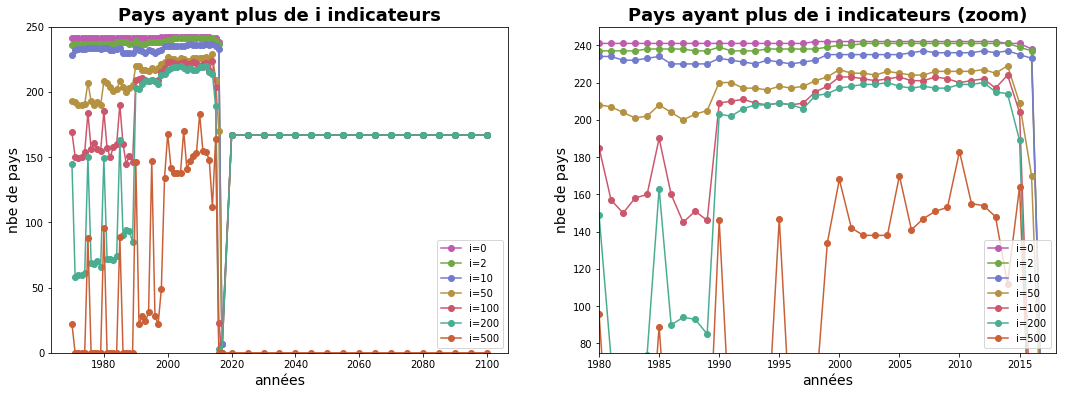

In [29]:
fig = plt.figure(figsize = (18,6))

colors = ["#bd5db0","#70a845","#727bcc","#b49242","#cc566c","#4aad92","#ca6037"]
labels = ["i="+str(i) for i in tab_n]

plot1 = plt.subplot(1,2,1)
[plot1.plot(x, y[:,i], '-o', label = labels[i], color = colors[i]) for i in range(len(tab_n))]
plot1.set_ylim(0,250)
plot1.legend(loc = 'lower right')
plot1.set_xlabel("années", fontsize = 14)
plot1.set_ylabel("nbe de pays", fontsize = 14)
plot1.set_title("Pays ayant plus de i indicateurs", fontsize = 18, fontweight = 'bold')

plot2 = plt.subplot(1,2,2)
[plot2.plot(x, y[:,i], '-o', label = labels[i], color = colors[i]) for i in range(len(tab_n))]
plot2.set_xlim(1980,2018)
plot2.set_ylim(75,250)
plot2.legend(loc = 'lower right')
plot2.set_xlabel("années", fontsize = 14)
plot2.set_ylabel("nbe de pays", fontsize = 14)
plot2.set_title("Pays ayant plus de i indicateurs (zoom)", fontsize = 18, fontweight = 'bold')
plt.show() 

- Tous les pays ont au moins 1 indicateur
- 167 pays ont des projections d'indicateurs (entre 200 et 500)
- les données sont très rares pour l'année 2018 (7 indicateurs pour la grande majorité des pays

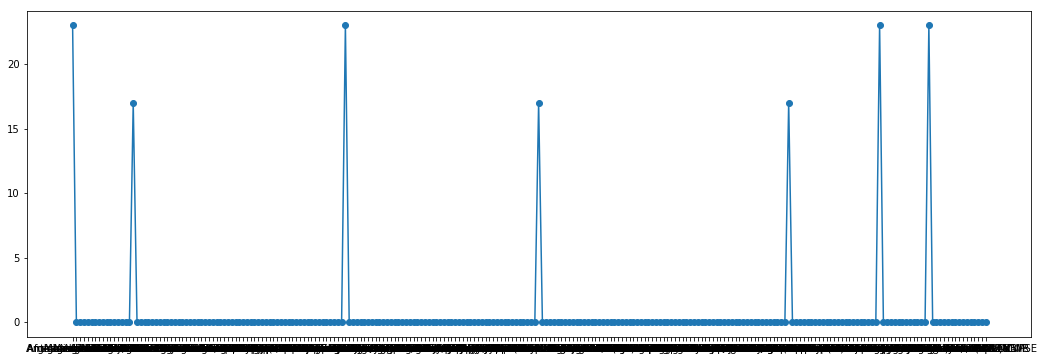

In [30]:
# Classement des pays en fonction du nombre d'indicateurs disponibles en 2017
fig = plt.figure(figsize = (18,6))
x = countrys
y = nb_ind_cnt['2017']
plt.plot(x, y, '-o')
plt.show() 

## Exploration des mots clés dans les noms d'indicateurs

In [31]:
def contAny (cars, mot):
    return any([True if c in cars else False for c in mot])

def contAll (cars, mot):
    return all([True if c in cars else False for c in mot])

def enum_mots_cmpt(li_phrases, nb): # prend une liste de phrases en entrée
    li_mots = " ".join(li_phrases).split(" ")
    li_mots_net = sorted([mot for mot in li_mots if (mot != '') \
                          and not contAll('-)%.(,', mot)])
    cpt = Counter(li_mots_net)
    words_occ = cpt.most_common(nb) # tableau de tuples
    words = [words_occ[i][0] for i in range(len(words_occ))]  
    occs = [words_occ[i][1] for i in range(len(words_occ))]
    dic_occs = dict() 
    for i in range(len(words_occ)):
        dic_occs[words[i]]=occs[i]
    return dic_occs # dictionnaire

def filt_dict(dic_t, li_pop):
    dic = dic_t
    [dic.pop(w) for w in li_pop if w in dic_t.keys()]
    return dic

In [32]:
def random_color_func(word=None, font_size=None, position=None, orientation=None, font_path=None, random_state=None):
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(np.random.randint(70, 120) / 255.0))
    return "hsl({}, {}%, {}%)".format(h, s, l)
tone = 10.0 # define the color of the words

def nuageMots(dic_occs): # prend un dictionnaire {"mot" : nbe occurences}
    fig = plt.figure(figsize=(18,8))
    wordcloud = WordCloud(width=1000,height=200, background_color='black', max_words=1628,\
                      relative_scaling=1, color_func = None, normalize_plurals=False)
    wordcloud.generate_from_frequencies(dic_occs)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()
    
def histMots(dic_occs): # prend un dictionnaire {"mot" : nbe occurences}
    fig = plt.figure(figsize=(18,4))
    tab_occs = np.array([[k,int(v)] for k,v in dic_occs.items()]).T   # dictionnaire en tableau
    x = tab_occs[0]
    y = tab_occs[1].astype(int)
    x_label = tab_occs[0]
    ax = plt.bar(x, y, align = 'center', color='b')
    plt.xticks(x, x_label, rotation=85, fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.ylabel("Nb. of occurences", fontsize = 18, labelpad = 10)
    plt.title("Fréquence des mots-clés",color='k',fontsize = 18, fontweight = 'bold')
    plt.show() # affiche l'histogramme

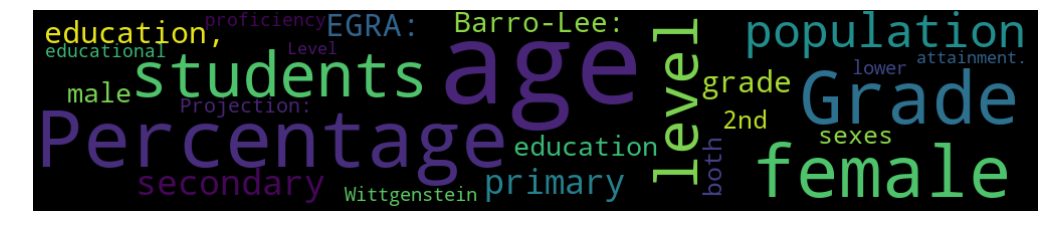

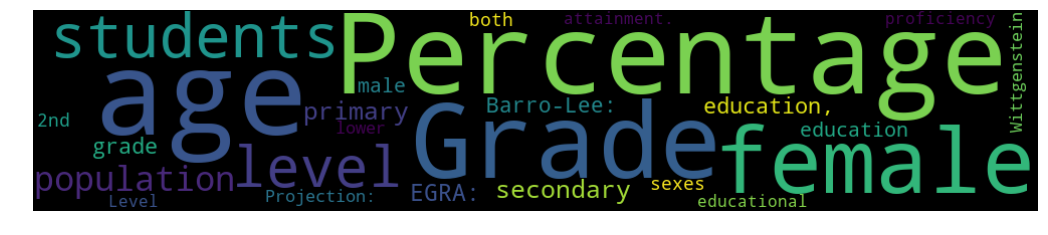

(None, None)

In [33]:
list_pop = ["in", "of", "a", "and", "Per", "by", "the", "with", "to", "from",\
            "for", "who", "on", "are"] # liste des mots non considérés

# génération dictionnaire effectif mots-clés 
dic_occs = enum_mots_cmpt(data["Indicator Name"], 30) # à parti des noms d'indicateurs dans "Data"
dic_occs = filt_dict(dic_occs,list_pop) # filtrage des mots indésirables
dic_occs2 = enum_mots_cmpt(data["Country Name"], 30) # à partir des indicateurs uniques
dic_occs2 = filt_dict(dic_occs,list_pop) # filtrage des mots indésirables

nuageMots(dic_occs), nuageMots(dic_occs2)

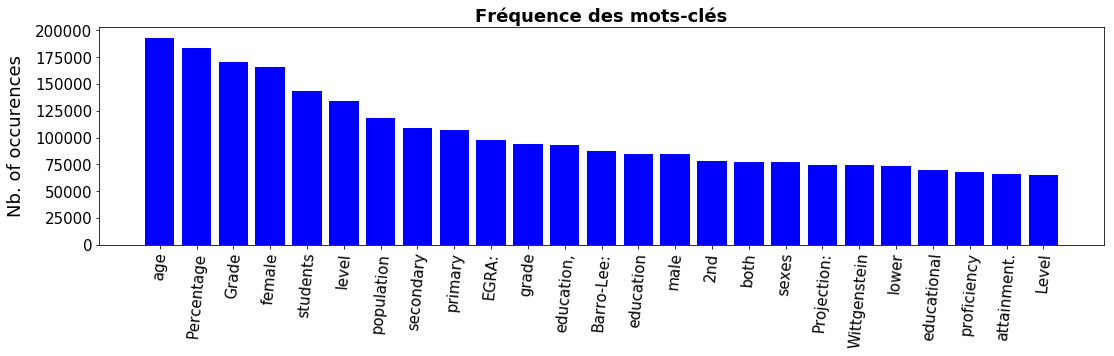

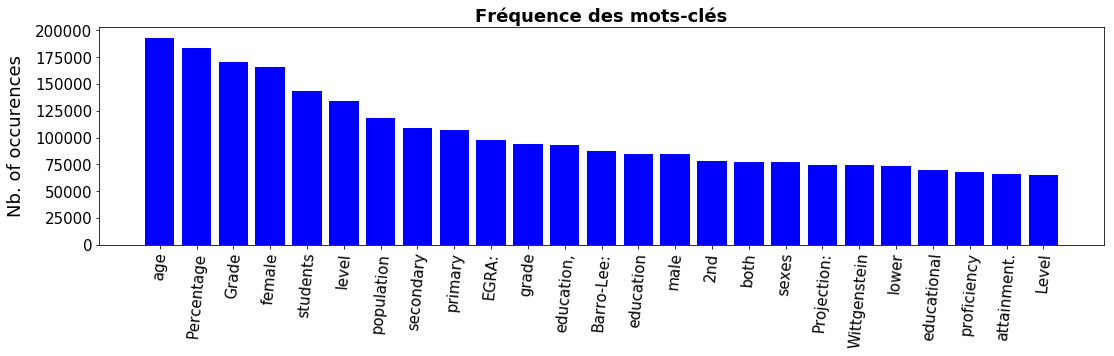

(None, None)

In [34]:
histMots(dic_occs), histMots(dic_occs2)

PBE A REGLER : les deux graphes sortent les mêmes résultats !!!!

In [35]:
dic_occs, dic_occs2

({'age': 193358,
  'Percentage': 183678,
  'Grade': 170852,
  'female': 165528,
  'students': 143748,
  'level': 134310,
  'population': 118580,
  'secondary': 108658,
  'primary': 106722,
  'EGRA:': 97526,
  'grade': 93896,
  'education,': 93412,
  'Barro-Lee:': 87120,
  'education': 84942,
  'male': 84942,
  '2nd': 78166,
  'both': 76714,
  'sexes': 76714,
  'Projection:': 74536,
  'Wittgenstein': 74536,
  'lower': 73326,
  'educational': 69938,
  'proficiency': 68002,
  'attainment.': 66066,
  'Level': 65340},
 {'age': 193358,
  'Percentage': 183678,
  'Grade': 170852,
  'female': 165528,
  'students': 143748,
  'level': 134310,
  'population': 118580,
  'secondary': 108658,
  'primary': 106722,
  'EGRA:': 97526,
  'grade': 93896,
  'education,': 93412,
  'Barro-Lee:': 87120,
  'education': 84942,
  'male': 84942,
  '2nd': 78166,
  'both': 76714,
  'sexes': 76714,
  'Projection:': 74536,
  'Wittgenstein': 74536,
  'lower': 73326,
  'educational': 69938,
  'proficiency': 68002,
  'at

generate(text) 	Generate wordcloud from text.

generate_from_frequencies(frequencies[, …]) 	Create a word_cloud from words and frequencies.

generate_from_text(text) 	Generate wordcloud from text.

process_text(text) 	Splits a long text into words, eliminates the stopwords.

recolor([random_state, color_func, colormap]) 	Recolor existing layout.

to_array() 	Convert to numpy array.

to_file(filename)

## Détection des outliers

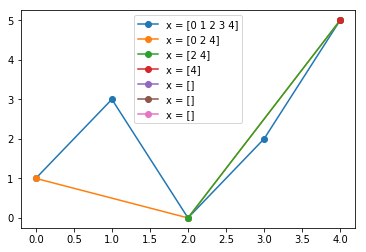

In [37]:
# prend un tableau de valeurs, calcule la moyenne, l'écart type
# et renvoie les valeurs au-delà ou en-deça de x fois l'écart type
def detOutliers(df,col,x):
    moy = df[col].mean()
    std = df[col].std()
    out_val = [nb for nb in df[col].values if ((nb<moy-(x*std)) or (nb>moy+(x*std)))]
    return df[df[col].isin(out_val)]

my_tab = [1,3,0,2,5]
df = pd.DataFrame({'my_col' : my_tab})

tab_df = [detOutliers(df, "my_col",x) for x in np.linspace(0,2.5,7)]
[plt.plot(df.index, df["my_col"].values,'o-', label = "x = "+str(df.index.values)) for df in tab_df]
plt.legend()
plt.show()

In [ ]:
data.T.index

TypeError: slice indices must be integers or None or have an __index__ method

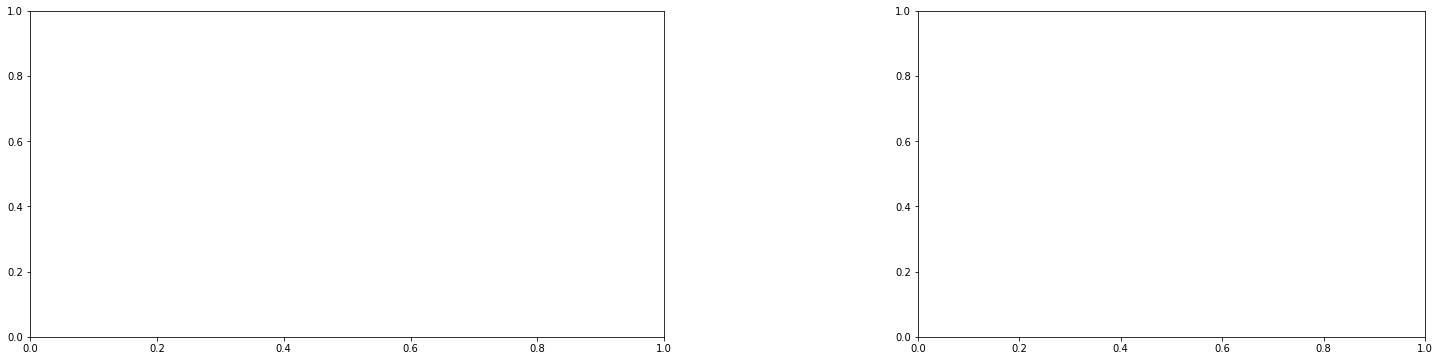

In [512]:
fig, (plot1, plot2) = plt.subplots(1, 2, figsize = (25,6), gridspec_kw={'width_ratios': [3, 2]})
x=[1,2,3]
y=[8,7,6]
# plot1.plot(x, y)
# plot2.plot(y, x)

plot1 = plt.subplot(1,2,1)
#data.boxplot(column = list(data.columns[4:52]))
plot1.boxplot(data[data.columns['1970':'2017']])
#plot1.set_ylim(-300,550050)

# plot2 = plt.subplot(1,2,2)
# plot2.boxplot(data_val_0)
# #data[data.columns[52:]].dropna(inplace = False).boxplot(data.columns[52:])
# plot2.set_ylim(-3,20)

plt.show()

## -------------- BROUILLONS -------------

In [40]:
## groupby, merge, join, concat etc.

#DataFrame.merge(right, how='inner', on=None, left_on=None, right_on=None, left_index=False,
# right_index=False, sort=False, suffixes=('_x', '_y'), copy=True, indicator=False, validate=None)
df1 = pd.DataFrame({'lkey': ['foo', 'bar', 'baz', 'foo'], 'value': [1, 2, 3, 1], 'value2': [100, 200, 300, 500]})
df2 = pd.DataFrame({'rkey': ['foo', 'bar', 'baz', 'foo'], 'value': [5, 6, 7, 8]})
#df1.merge(df2, right_on='rkey')
df1.merge(df2, left_on = 'lkey', right_on='rkey')
df1.groupby(['value', 'lkey']).count()

,,value2
value,lkey,
1,foo,2
2,bar,1
3,baz,1


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


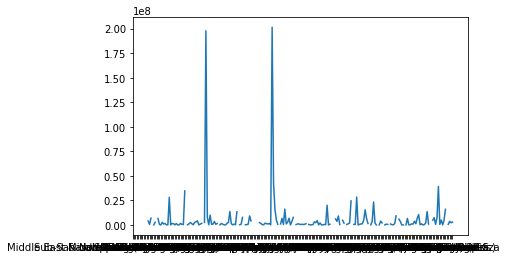

In [87]:
my_df = data[data["Indicator Code"]=='SP.POP.1524.TO.UN']
my_df.dropna(how = 'all', inplace = True)
x = my_df["Country Name"]
y = my_df["2000"]
# pop de 15 à 24 ans en 2000 selon les pays :
plt.plot(x,y)
plt.show()